In [2]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [4]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [5]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

## Overview of analysis
So we want to take a look at what the high prior knowledge are doing. Remember that we have 22 such students, 19 HH and 3 HL. Let's keep the HL and call HH+HL = HH

In [6]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [7]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


We want to compare the three groups to each other. We would like to know if:
- HH look like LL in which case LL use experts strategies that are productive with certain level of prior knowledge
- HH look like LH in which case they used productive strategies

We need to make a new funciton to run the sequence mining with 3 groups.

### Let's make those three groups

In [8]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

### Let's run the sequence mining like we usually do on all 3 groups

In [9]:
students = list(set(get_students()) - set(df_scores[df_scores['three groups']=='HL']['student']))
CUT_OFF = 0.30 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'three groups'
level1 = 'LH'
level2 = 'LL'
level3 = 'HH'
family_category = "Family"
group_sizes = np.array([len(set(df_scores[df_scores['three groups']==level1]['student'])),len(set(df_scores[df_scores['three groups']==level2]['student'])),len(set(df_scores[df_scores['three groups']==level3]['student']))])


BINS = 1
axis = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          BINS,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops_group = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
axis = None
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='HH',ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}
tops_both = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

axis = 0
tops_time = get_top_seqs(rank_sequences(sequence_counts_both,BINS,axis),15)

Getting sequence use over 1 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 30% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 93 students split by three groups. 
    Keeping only sequences used once by at least 30% of students 
    in each group and overall.


In [10]:
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]
tops_group.sort(key=lambda x: -x[1])
for seq,ig in tops_group:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
    tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
    chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)
    res = (tb - ex)/np.sqrt(ex)
    cmarg = np.array(tb).sum(axis=0)
    rmarg = np.array(tb).sum(axis=1)
    n = np.array(tb).sum()
    res_adj = res
    res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
    row = [seq, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
    table.append(row)
print tabulate(table)
np.savetxt("by_group_threshold30.csv", table, delimiter=",", fmt='%s')

--------  ----  --  --  --  -----  -----  ------  ------  ------
SEQ       IG    LH  LL  HH  chi^2  p-val  LH-res  LL-res  HH-res
CPCTcCP   0.35  10  30  5   7.597  0.022  -1.42   2.71    -1.55
TbPTbC    0.32  7   8   31  7.414  0.025  -1.2    -1.04   2.72
TbPCPCP   0.31  5   13  31  7.295  0.026  -2.01   -0.02   2.48
PTcPTc    0.26  31  25  5   4.916  0.086  1.49    0.24    -2.11
TcCTs     0.25  21  30  5   4.721  0.094  -0.09   1.69    -1.93
PTsPCTs   0.25  31  5   21  8.065  0.018  2.48    -2.68   0.21
CPCTsC    0.22  13  36  10  7.475  0.024  -1.63   2.72    -1.31
PTcCTc    0.2   47  33  10  7.648  0.022  2.19    -0.17   -2.46
TsCTsC    0.19  15  36  10  6.352  0.042  -1.3    2.48    -1.41
TcCPCP    0.18  7   30  26  6.348  0.042  -2.49   1.92    0.71
CTcCTcCP  0.18  7   30  26  6.348  0.042  -2.49   1.92    0.71
PTcCTcP   0.17  31  13  10  4.999  0.082  2.22    -1.24   -1.2
PCTcCP    0.16  21  36  10  4.84   0.089  -0.68   2.02    -1.61
PCPTs     0.14  26  11  36  5.223  0.073  0.

In [11]:
table = [['SEQ','IG','t1','t2','t3', 't4']]
tops_time.sort(key=lambda x: -x[1])
for seq,ig in tops_time:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_time[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum((sequence_counts_both[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --  --
SEQ      IG    t1  t2  t3  t4
CPTb     1.41  30  1   0   2
TbPTb    1.37  17  3   0   0
TbPTbC   1.29  11  3   0   0
TbCPC    1.19  27  3   0   3
CTbCP    1.09  25  2   1   2
PTbC     1.08  29  3   2   1
TbCTbP   1.02  22  2   4   0
TbCP     1.02  32  4   1   3
PTb      0.97  39  5   3   2
CTbPCP   0.91  12  0   6   1
CTbPC    0.75  31  2   10  3
TbCTb    0.74  34  3   6   3
PTsPCTs  0.72  13  8   1   0
CTbP     0.68  41  5   10  4
TbPCP    0.64  19  2   5   2
-------  ----  --  --  --  --


In [12]:
table = [['SEQ','IG','LH','LL','HH','t1','t2','t3','t4']]
tops_both.sort(key=lambda x: -x[1])
for seq,ig in tops_both:
#     print seq, round(ig,3), np.ndarray.tolist(sequence_counts_both[seq].T*group_sizes)[0]
    row = [seq,str(round(ig,2))] + [int(x*100) for x in np.sum(sequence_counts_both[seq], axis=1)] + [int(x*100) for x in np.sum((sequence_counts_both[seq].T*group_sizes).T, axis=0)/sum(group_sizes)]
    table.append(row)
print tabulate(table)

-------  ----  --  --  --  --  --  --  --
SEQ      IG    LH  LL  HH  t1  t2  t3  t4
TbPTbC   1.74  7   11  36  11  3   0   0
TbPTb    1.62  18  13  36  17  3   0   0
CPTb     1.53  36  27  36  30  1   0   2
TbCPC    1.32  42  30  26  27  3   0   3
PTbC     1.24  31  36  42  29  3   2   1
CTbCP    1.23  34  27  31  25  2   1   2
PTsPCTs  1.19  36  5   31  13  8   1   0
TbPCPCP  1.14  10  13  31  9   2   3   1
TbCTbP   1.13  23  30  36  22  2   4   0
TbCP     1.12  47  33  42  32  4   1   3
CTbPCP   1.12  15  19  31  12  0   6   1
PTb      1.05  52  41  63  39  5   3   2
TbPCPC   1.04  18  13  31  11  2   4   1
TcCTs    1.04  23  30  5   5   5   11  0
PCTbP    0.94  21  19  36  13  3   2   4
-------  ----  --  --  --  --  --  --  --


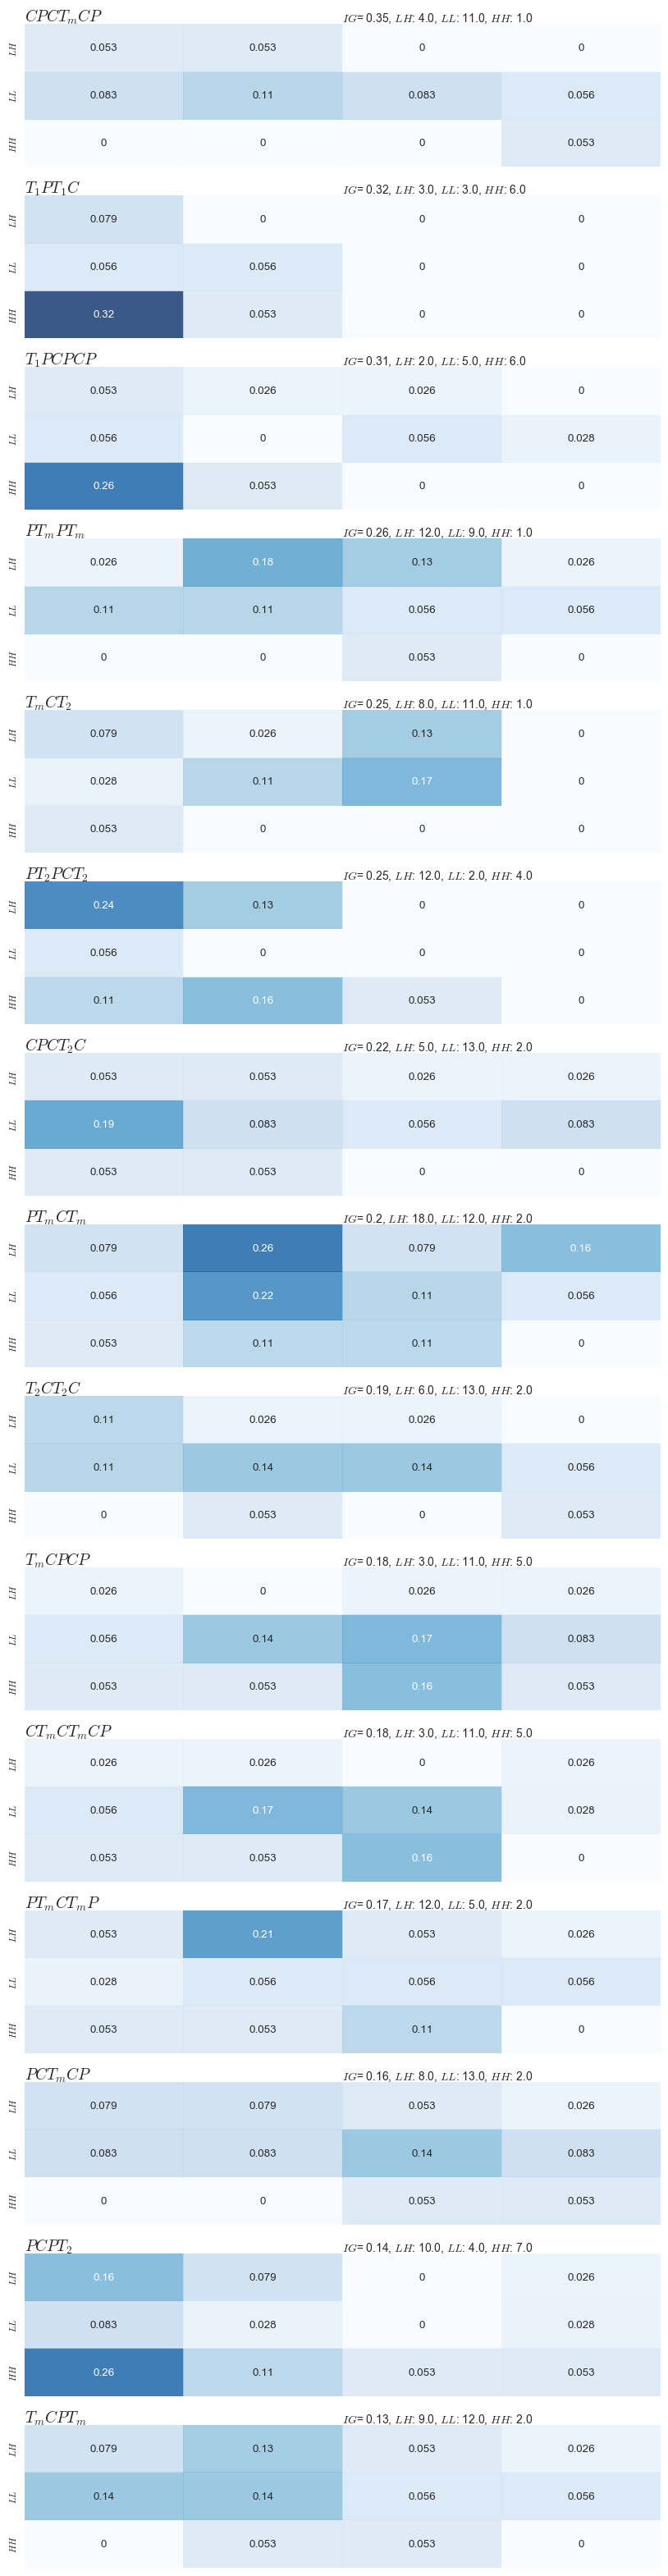

In [13]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops_group)[0]
fig, axes = plt.subplots(len(tops_group),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops_group):
    ax = axes[i]
    data = sequence_counts_both[seq]
    hl,ll,hh = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,hh), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

### Specific sequence look-up

In [37]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0)]
table = [['SEQ','IG','LH','LL','HH','chi^2','p-val', 'LH-res', "LL-res", 'HH-res']]

seq = 'Tc'
lh,ll,hh = (sequence_counts_group[seq].T*group_sizes)[0]
tb = [[lh, group_sizes[0]-lh], [ll, group_sizes[1]-ll], [hh, group_sizes[2]-hh]]
chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)
res = (tb - ex)/np.sqrt(ex)
cmarg = np.array(tb).sum(axis=0)
rmarg = np.array(tb).sum(axis=1)
res_adj = res
res_adj[:,0] = res_adj[:,0]/np.sqrt(1-rmarg/n)/np.sqrt(1-cmarg[0]/n)
n = np.array(tb).sum()
row = [seq, str(round(ig,2))] + [int(x*100) for x in list(np.ndarray.tolist(sequence_counts_group[seq].T)[0])] + [round(chi2, 3), round(p, 3)] + [round(r,2) for r in res_adj[:,0]]
table.append(row)
print tabulate(table)

---  ---  --  --  --  -----  -----  ------  ------  ------
SEQ  IG   LH  LL  HH  chi^2  p-val  LH-res  LL-res  HH-res
Tc   0.0  92  97  89  1.459  0.482  -0.47   1.15    -0.81
---  ---  --  --  --  -----  -----  ------  ------  ------


### Single actions:

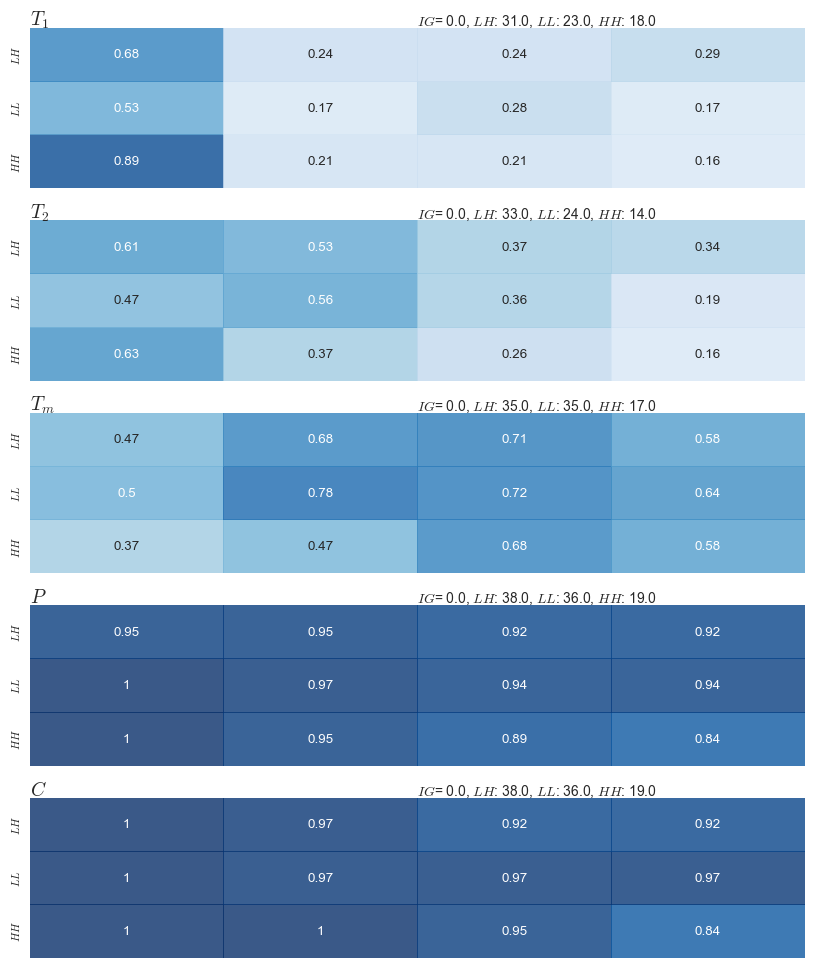

In [15]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0),]
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*all_actions)[0]
fig, axes = plt.subplots(len(all_actions),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])

for i,(seq,ig) in enumerate(all_actions):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,h_ = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $HH$: {3}".format(str(round(ig,2)),hl,ll,h_), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,12)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$HH$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

### Let's analyze the building blocks

In [19]:
blocks_LH, time_coords_LH =  get_blocks_withTime_new(df,get_students('three groups','LH'),"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,get_students('three groups','LL'),"Family",start=False,ignore=['I'], as_list=True)
blocks_HH, time_coords_HH =  get_blocks_withTime_new(df,get_students('three groups','HH'),"Family",start=False,ignore=['I'], as_list=True)

In [20]:
def get_frequencies(seq_of_interest,blocks1,blocks2,blocks3,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest) for student,seq in blocks3.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi-1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi-1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/(len(seq)-len_seqi-1) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks3.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
        freq3 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks3.iteritems()}
    return freq1.values(),freq2.values(),freq3.values()

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_continuous(seq_of_interest,freq_LH,freq_LL,freq_HH):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    alldata = np.concatenate((freq_LH, freq_LL, freq_HH), axis=0)
    binsize = max(alldata)/10.
    bins = np.arange(0,max(alldata)+binsize,binsize)
#     plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
#     plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
#     plt.hist(freq_HH,color = 'g',alpha = 0.4,bins = bins)
    plt.hist([freq_LH,freq_LL,freq_HH], bins=bins, stacked=True)
    plt.title("Use of the sequence ''{0}'' by LH (red) and LL (blue) and HH (purple)".format(seq_of_interest))
    return plt

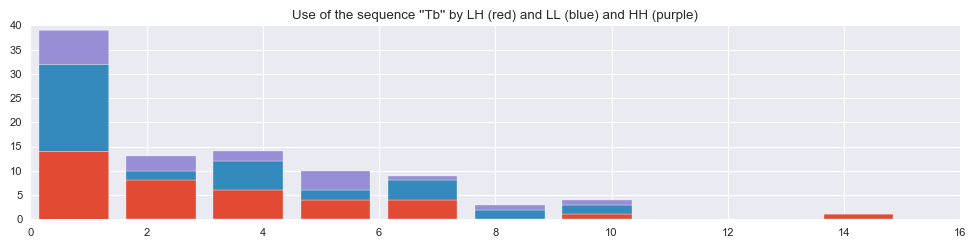

In [21]:
seq = 'Tb'
freq_LH,freq_LL,freq_HH = get_frequencies(seq,blocks_LH,blocks_LL,blocks_HH,normalize_by=None)
plot = make_hist_continuous(seq,freq_LH,freq_LL,freq_HH)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)
# freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
# plot = make_hist_continuous(seq,freq_HL,freq_LL)
# plot.show()
# perform_comparative_stats(seq,freq_HL,freq_LL)

Comparing the median frequency usage of sequence TsC normalized by Ts
Kruskal omnibus test: H statistic = 2.4135417986, p<0.299161744813
Dunn's pairwise post hoc test with Bonferonni:
LH vs LL: Z score = 0.654466120586, p<1.0
LH vs HH: Z score = 1.02645532366, p<0.914031036069
LL vs HH: Z score = 1.55387391207, p<0.360643486965


/Users/jonathanma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: We see ties.


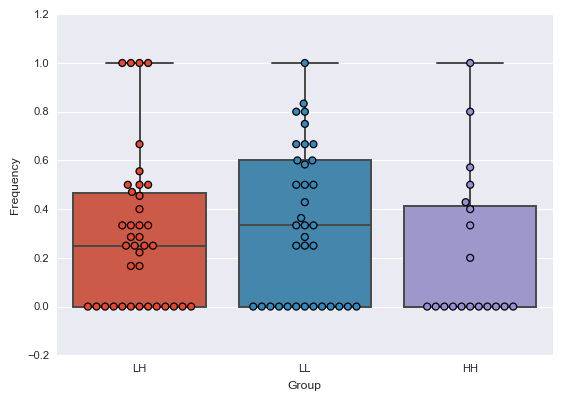

In [82]:
seq = 'TsC'
# norm = 'length'
norm = 'Ts'
freq_LH,freq_LL,freq_HH = get_frequencies(seq,blocks_LH,blocks_LL,blocks_HH,normalize_by=norm)
freqname = 'Frequency'
groupname = 'Group'

df0 = pd.DataFrame(freq_LH, columns=[freqname])
df0[groupname] = 'LH'
df1 = pd.DataFrame(freq_LL, columns=[freqname])
df1[groupname] = 'LL'
df2 = pd.DataFrame(freq_HH, columns=[freqname])
df2[groupname] = 'HH'
df = df0.append(df1).append(df2).reset_index()
# df.boxplot('freq',by='group')

ax = sns.boxplot(x=groupname, y=freqname, data=df)
ax = sns.swarmplot(x=groupname, y=freqname, data=df, edgecolor="black", linewidth=.9)

# F, p = stats.kruskal(freq_LH,freq_LL,freq_HH)
# print F, p
print "Comparing the median frequency usage of sequence {0} normalized by {1}".format(seq, norm)
H, p_omnibus, Z_pairs, p_corrected, reject = kw_dunn([freq_LH,freq_LL,freq_HH])
print "Kruskal omnibus test: H statistic = {0}, p<{1}".format(H, p_omnibus)
print "Dunn's pairwise post hoc test with Bonferonni:"
print "LH vs LL: Z score = {0}, p<{1}".format(Z_pairs[0], p_corrected[0])
print "LH vs HH: Z score = {0}, p<{1}".format(Z_pairs[1], p_corrected[1])
print "LL vs HH: Z score = {0}, p<{1}".format(Z_pairs[2], p_corrected[2])


In [17]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings


def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """

    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test

    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations

    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.

    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)

    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)

    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic

    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal

    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison

    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.

    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha

    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.

    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.chisqprob(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):
        
        # standardized score
        ts3_ts = list(np.unique(allgroups, return_counts=True)[1])
        E_ts3_ts = sum([x**3 - x for x in ts3_ts if x>1])

        if sum([x>1 for x in ts3_ts]) > 0:
            warnings.warn("We see ties.")

            yi = np.abs(Rmean[ii] - Rmean[jj])
            theta10 = (N * (N + 1)) / 12
            theta11 =  E_ts3_ts / ( 12* (N - 1) )
            theta2 = (1. / n[ii] + 1. / n[jj])
            theta = np.sqrt( (theta10 - theta11) * theta2 )
            Zij = yi / theta
        else:
            Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
                   np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        
#         # standardized score
#         Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
#                np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject